### Recalled Food Products in the United States: Exploratory Data Analysis
### BIOS 669: Final Project
#### University of North Carolina at Chapel Hill
#### Joyce Choe 
#### April 30, 2024

### Surveillance study

##### Data Source #1
The [Food Enforcement Report](https://open.fda.gov/apis/food/enforcement/) is a publicly available database from 2004 to present of recalled food products that failed to meet regulations for public health and safety set by the Food & Drug Administration (FDA). The FDA monitors all recalled food products voluntarily submitted by firms or raised by the FDA. Recalled food products are dated, classified, and retrievable through the [FDA Recall Enterprise System (RES)](https://open.fda.gov/data/res/), a real-time data capturing system where recalls are recorded and updated on a weekly basis.

##### Data Source #2
An [infographic](https://www.ams.usda.gov/services/local-regional/rfbcp) created by the USDA (US Department of Agriculture) Regional Food Business Centers Program "looked-up" to categorize a firm's location in the United States to a USDA geographic region. I retained eleven U.S. regions:  Northwest and Rocky Mountain, Southwest, North Central, Heartland, Rio Grande Colonias, Great Lakes Midwest, Delta, Appalachia, Northeast, Southeast, and Islands and Remote Areas. For regions outside of the U.S., I created an "International" category.

#### Project Aims
This project will conduct exploratory data analysis (EDA) to highlight trends in the Food Enforcement Report dataset for recalls distributed to North Carolina only. The discoveries will facilitate statistical analyses for where and when recalled food products distributed to NC are likely to occur.
1. To explore recalls distributed to NC based on year
2. To explore recalls distributed to NC based on a firm's location by region inside or outside the United States
2. To explore recalls distributed to NC based on recall reason
3. To explore recalls distributed to NC based on notification method
4. To calculate the number of days between initiation and termination dates for processing a recall and evaluate how this derived variable differs by year, region, recall reason, classification, and notification method

### Steps:
1. Load data from source
2. Merge datasets to combine into one dataset and clean data
3. Visualize dataset with useful descriptive statistics and plots
4. Develop a codebook for understanding the final dataset structure and variables

## 1. Load data from source
The data from the food enforcement report are requested from [openFDA API](https://open.fda.gov/apis/), which returns the requested results as JSON (JavaScript Object Notation). By requesting an Application Programming Interface (API) call via SAS, I queried for results on terminated recalls distributed to North Carolina between January 1, 2013 to December 31, 2023.

In [1]:

OPTIONS nonotes nosource;
OPTIONS nodate mergenoby=warn varinitchk=warn nofullstimer;

* API data by yearly intervals (1/2013 to 12/2023);
%MACRO recall(n=, dates=);

filename recall&n temp;

proc http
	url="%nrstr(https://api.fda.gov/food/enforcement.json?&search=status:%22Terminated%22
	+AND+distribution_pattern:(*nc*+OR+*North*Carolina*+OR+*nation*+OR+*domestic*)+AND+recall_initiation_date:[)&dates%nrstr(]&sort=recall_initiation_date:asc&limit=1000)"
	method="GET"
	out=recall&n;
run;

/*save in Libraries > My Libraries > food&n */
libname food&n JSON fileref=recall&n; 

* Add a column for data set name;
proc sql; 
	create table food&n(drop=ordinal_root ordinal_results address_1 address_2 postal_code city code_info more_code_info report_date) as
	select *, "food&n" as ds
	from food&n..results;
quit;

%MEND;

/*include all observations with recall initiation dates without gap between dates that are not beyond limit=1000 */
%recall(n=1, dates=20130101+TO+20130601);
%recall(n=2, dates=20130601+TO+20131231);
%recall(n=3, dates=20140101+TO+20140601);
%recall(n=4, dates=20140601+TO+20141231);
%recall(n=5, dates=20150101+TO+20150601);
%recall(n=6, dates=20150601+TO+20151231);
%recall(n=7, dates=20160101+TO+20160601);
%recall(n=8, dates=20160601+TO+20161231);
%recall(n=9, dates=20170101+TO+20170601);
%recall(n=10, dates=20170601+TO+20171231);
%recall(n=11, dates=20180101+TO+20181231);
%recall(n=12, dates=20190101+TO+20191231);
%recall(n=13, dates=20200101+TO+20201231);
%recall(n=14, dates=20210101+TO+20211231);
%recall(n=15, dates=20220101+TO+20221231);
%recall(n=16, dates=20230101+TO+20231231);



SAS server started using Context SAS Studio compute context with SESSION_ID=194b43cc-1af9-4ab4-8bc0-d083933d9d37-ses0000
12   ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
12 ! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml.htm
13   
14   
15   OPTIONS nonotes nosource;



## 2. Merge datasets to combine into one dataset and clean data

* Sixteen datasets were merged into one dataset 
* Derive year of recall from recall_initiation_date
* Derive date1 as numeric date from recall_initiation_date
* Derive date4 as numeric date from termination_date
* Subset to recalls with terminated status 
* Subset to recalls with non-missing values based on Table 1 variables
* Subset dataset to unique recall event IDs (n=1828)
* Derive usda_region from firm location based on state and data source #2
* Derive number of days between recall initiation and termination dates
* Derive general_reason from reason_for_recall
* Label variables

In [2]:
options notes source;

* Combine all data sets and adjust length of var so that none have truncated warning;
data combineall(drop=ds) missing;
	length ds $20 reason_for_recall $2000 product_quantity $500 distribution_pattern $2000 
	state $100  country $100 product_description $5000 recalling_firm $300;
	
	set food: ;
	
	* edits: new variable for year;
	date1year=substr(recall_initiation_date,1,4);
	
	*change to numeric SAS date type;
	date1=input(recall_initiation_date, yymmdd8.);
	date4=input(termination_date, yymmdd8.);
	
	*format to readable dates;
	format date1 date4 date9.;
	
	* count number of missing rows;
	count_missing = cmiss(reason_for_recall, distribution_pattern, state,
	country, classification, event_id, voluntary_mandated, status, recall_initiation_date, 
	termination_date, initial_firm_notification);
 
 	* keep only non-missing dataset;
 	if count_missing>0 then output missing;
 	else output combineall;
 	
 	* drop count_missing;
 	drop count_missing;

    * keep only recalls with terminated status;
    if status = "Terminated";
run;


proc sort data=combineall nodupkey out=recallevents;
	by event_id;
run;

66   
67   * Combine all data sets and adjust length of var so that none have truncated warning;
68   data combineall(drop=ds) missing;
69   	length ds $20 reason_for_recall $2000 product_quantity $500 distribution_pattern $2000
70   	state $100  country $100 product_description $5000 recalling_firm $300;
71   	
72   	set food: ;
73   	
74   	* edits: new variable for year;
75   	date1year=substr(recall_initiation_date,1,4);
76   	
77   	*change to numeric SAS date type;
78   	date1=input(recall_initiation_date, yymmdd8.);
79   	date4=input(termination_date, yymmdd8.);
80   	
81   	*format to readable dates;
82   	format date1 date4 date9.;
83   	
84   	* count number of missing rows;
85   	count_missing = cmiss(reason_for_recall, distribution_pattern, state,
86   	country, classification, event_id, voluntary_mandated, status, recall_initiation_date,
87   	termination_date, initial_firm_notification);
88   
89    	* keep only non-missing dataset;
90    	if count_missing>0 then output m

In [3]:
options source notes;
proc sql;
create table rfbc_states as
	select *,
	case 
		when state in ('NM','TX') then 'Rio Grande Colonias'
		when state in ('AK','HI','PR') then 'Islands & Remote Areas'
		when state in ('ND','SD','MN') then 'North Central'
		when state in ('CA','NV','AZ','UT') then 'Southwest'
		when state in ('WI','IL','IN','MI') then 'Great Lakes Midwest'
		when state in ('AR','LA','MS','AL') then 'Delta'
		when state in ('TN','KY','WV','OH') then 'Appalachia'
		when state in ('NE','KS','OK','MO','IA') then 'Heartland'
		when state in ('VA','NC','SC','GA','FL') then 'Southeast'
		when state in ('WA','OR','ID','MT','WY','CO') then 'Northwest & Rocky Mountain'
		when state in ('MD','DE','PA','NJ','NY','CT','RI','MA','NH','VT','ME') then 'Northeast'
		else 'International'
	end as usda_region
	from recallevents
	order by usda_region;
quit;

data datdiff;
	set rfbc_states;
	if ^missing(date1) and ^missing(date4) then do;
	days = intck('day', date1, date4);
	end;
run;

data reasons;
	set datdiff;
	length general_reason $30;
	if ^missing(reason_for_recall) then do;
	if prxmatch("/may|potential|...caution|risk|possible/i", reason_for_recall) > 0 then general_reason = "Precaution";
	else if prxmatch("/sanita|wash|uncook|raw|gmp|pasteur|process|prepared/i", reason_for_recall) > 0 then general_reason = "Unprepared";
	else if prxmatch("/lister|mon(ella|o)|hep\s|bacter|coli|spora|mold|yeast|bacillu|staph|pseudom|botu|pathog/i", reason_for_recall) > 0 then general_reason = "Microbe";
	else if prxmatch("/declare|allerg|gluten|label|content|statement|list(ed|s|ing)/i", reason_for_recall) > 0 then general_reason = "Mislabelled";
	else if prxmatch("/foreign|material|rock|object|metal|glass|plastic|fragment|icide|lead|arsenic|nsect/i", reason_for_recall) > 0 then general_reason = "Contaminant";
	else general_reason = "Other";
	end;
run;

* Final analysis data set (n=1828, 23 variables);
data recalls;
	set reasons;
	* shorthand variable value;
	if initial_firm_notification = 'Two or more of the following: Email, Fax, Letter, Press Release, Telephone, Visit'
	then initial_firm_notification = 'Two or more';
	else initial_firm_notification = initial_firm_notification;

    * rename variable to shorter name;
    rename initial_firm_notification = notification;
    
    	* labels for each variable;
	label reason_for_recall	= 'actual statement on reason for recall' 
	 	  product_quantity = 'amount of food product'
	 	  distribution_pattern = 'places where recall was distributed'
	 	  state = 'state of firm location'
	 	  country = 'country of firm location'
	 	  product_description = 'description of food product'
	 	  recalling_firm = 'name of firm'
	 	  center_classification_date = 'date when recall was classified with hazard risk level'
	 	  classification = 'hazard risk level assigned by FDA: Class I (adverse), Class II (less adverse), Class III (unlikely to be adverse)'
	 	  date1year = 'year of recall initation date'
	 	  days = 'number of days between initiation to termination date'
	 	  recall_number = 'alphanumeric tracking number assigned by FDA  to a specific recalled product'
	 	  initial_firm_notification = 'method by which public were notified of recall'
	 	  product_type = 'type of recalled product'
	 	  event_id = 'numerical tracking number assigned by FDA to a specific recall event'
	 	  termination_date = 'date when recall was closed for investigation'
	 	  recall_initiation_date= 'date when recall was first notified to public or consignees of a recall'
	 	  voluntary_mandated = 'status of whether recall was initated voluntarily by a firm or mandated by statutory recall authority, court order, or FDA'
		  status = 'progress of recall, indication whether terminated or ongoing'
		  date1 = 'recall_initiation_date' /*SAS numeric*/
		  date4 = 'recall_termination_date' /*SAS numeric*/
		  usda_region = 'location of firm by food business center region'
		  general_reason = 'reason for recall';	 
    
run;

ods noproctitle;
title 'Final analysis data set';
ods exclude EngineHost;
proc contents data=recalls;
run;

* Check derived variables: 
    - *date1year*: recall initiation year  

    - *date1*:  recall initiation date

    - *date4*:  recall termination date
    
    - *usda_region*: location of firm by region
    
    - *days*: days between initiation and termination dates
    
    - *general_reason*: parsed reason for recall
    


In [4]:

ods noproctitle;

* Check character variables;

title 'Check date1year';
proc freq data=recallevents nlevels;
    table date1year / missing list nocum nopercent;
run;

title 'Check usda_region';
proc freq data=rfbc_states order=freq nlevels;
	table usda_region / missing list nocum nopercent;
run;
title;

proc freq data=rfbc_states nlevels order=freq;
	table state*usda_region / missing list nocum nopercent;
run;
title;

proc freq data=rfbc_states nlevels order=freq;
	table country*usda_region / missing list nocum nopercent;
run;
title;

title 'Check general_reason';
proc freq data=reasons order=freq;
	table general_reason / missing list;
run;
title;


* Check numeric variables;

title 'Check date1, date4, days';
proc tabulate data=datdiff;
	var date1 date4 days;
	table date1 date4,
	n nmiss (min max median)*f=date9. range;
title;
    table days, 
    n nmiss min max median mean range ;
run;




#### Table 1. Variables of Interest from final analysis dataset

| # | Variable Name | Description |
|----| -------- | ------- |
|1| classification | hazard risk level assigned by FDA:  Class I (adverse), Class II (less adverse), Class III (unlikely to be adverse) |
|2| date1year* | Year of recall initiation date |
|3| days* | Number of days between termination and initiation dates |
|4| distribution_pattern | Places where recalled food products were distributed|
|5| general_reason* | General reason for recall |
|6| notification | Recall notification method |
|7| reason_for_recall | Actual statements on reason for recall|
|8| recall_initiation_date | Date when recall was first notified|
|9| recall_termination_date | Date when recall investigation was closed |
|10| state | Location of firm by U.S. state |
|11| status | Indication of whether recall was terminated or ongoing | 
|12| usda_region* | Location of firm by food business center region via USDA (US Dept. of Agriculture) |

\* = derived from source variables

## 3. Visualize dataset with useful descriptive statistics and plots


### Recall frequency & summary statistics by: 
* year
* region
* recall reason
* notification method
* classification (hazard)

#### Dotplots


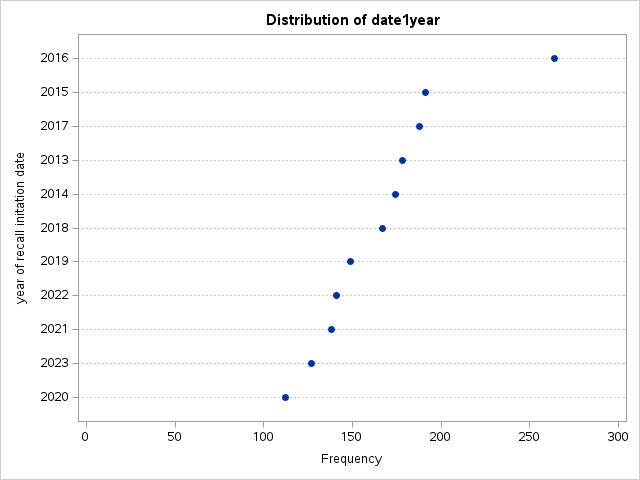
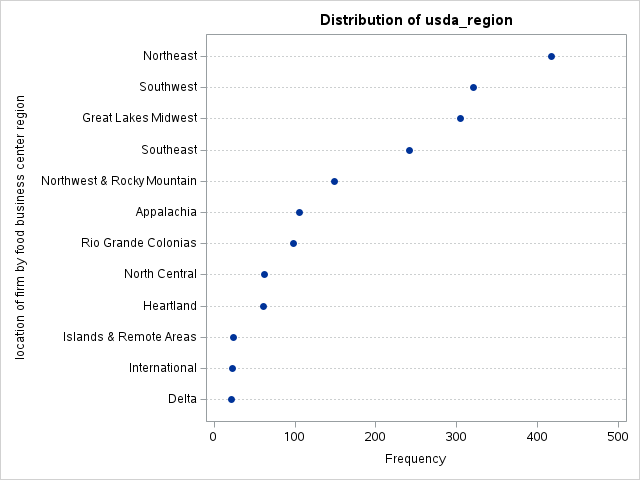
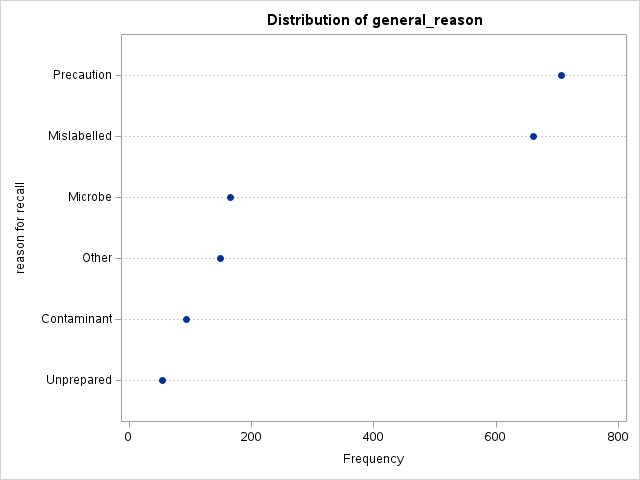
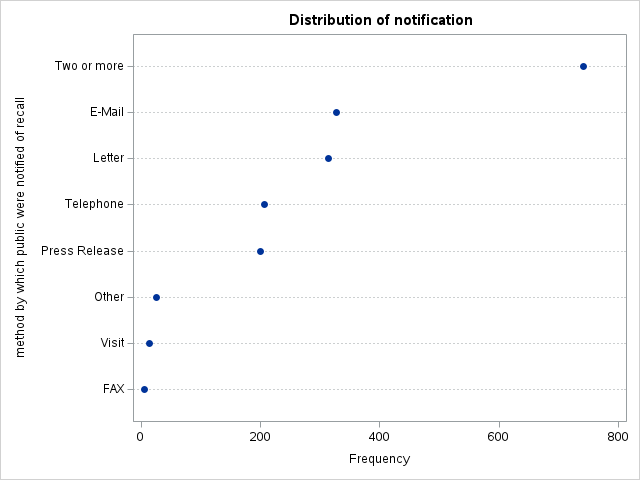
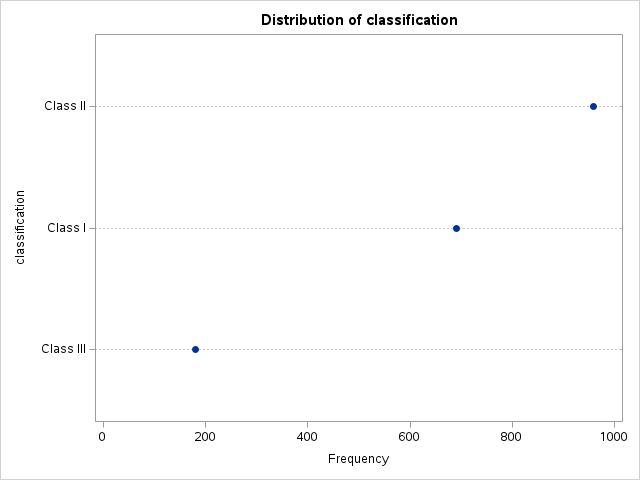

In [5]:
* number of recalls by categorical variable;

%macro dotplot(var=);

proc sql;
    create table freqdate_&var as 
    select count(&var) as count_&var, &var
    from recalls
    group by &var;
quit;

proc sort data=freqdate_&var;
    by count_&var;
run;

title "Number of recalls by &var.";
proc freq data=freqdate_&var order=data;
   tables &var / plots=freqplot(type=dotplot) nocum ;
    weight count_&var;
run;
title;

title "Average number of recalls by &var.";
proc means data=freqdate_&var maxdec=0 mean std median range n nmiss;
	var count_&var;
run;
title;

%mend;

%dotplot(var=date1year);
%dotplot(var=usda_region);
%dotplot(var=general_reason);
%dotplot(var=notification);
%dotplot(var=classification);



### Recall proportion each year by:
* region
* recall reason
* notification method
* classification (hazard)

#### Stacked proportional barplots over time


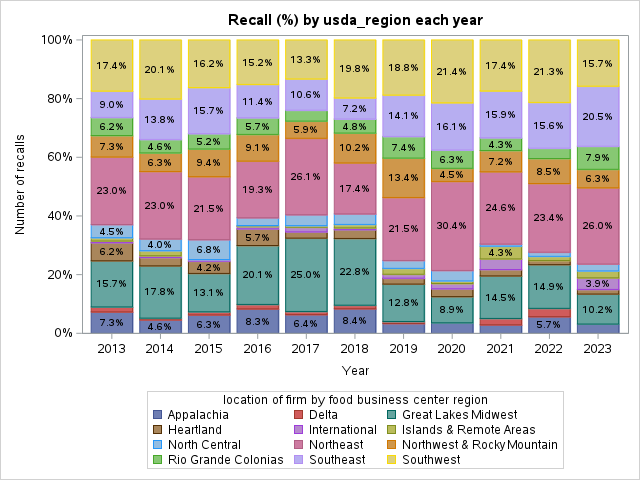
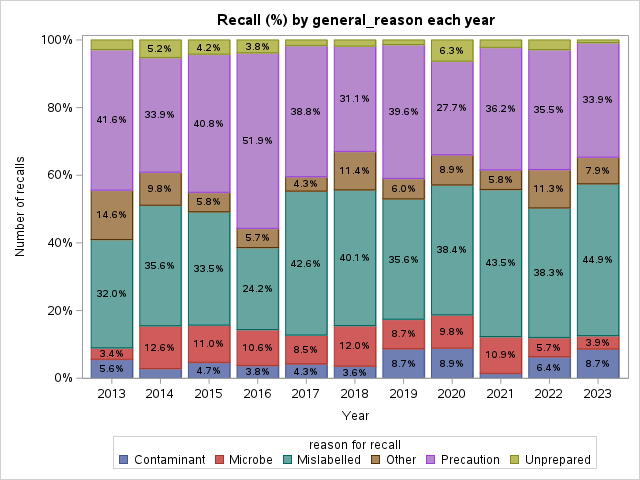
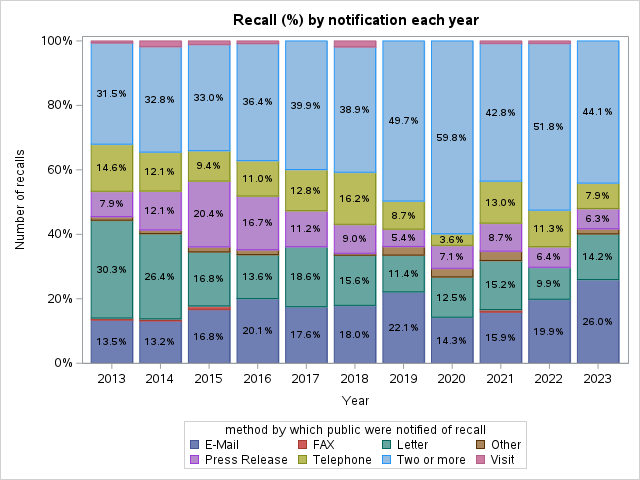
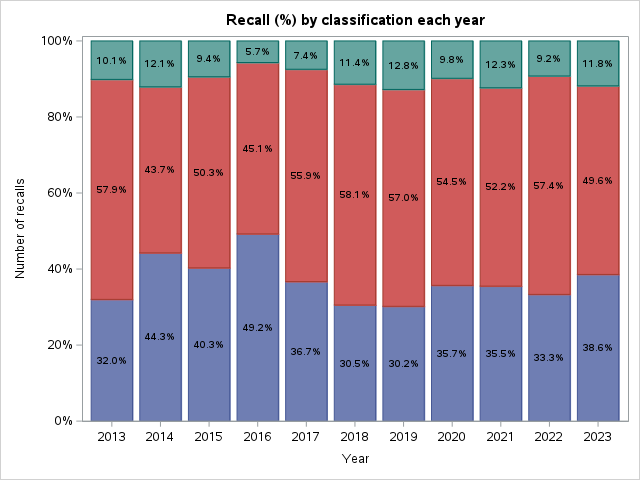

In [6]:

* output freqcount data set;
proc freq data=recalls noprint;
	table date1year*usda_region/ out=freqcount1;
	table date1year*general_reason / out=freqcount2;
	table date1year*notification/ out=freqcount3;
	table date1year*classification / out=freqcount4;
run;

*freq recalls (%) by categorical variable per year;

%macro stackedbar(num=, var=);

title "Recall (%) by &var each year";
proc sgplot data=freqcount&num pctlevel=group;
	vbar date1year / response=count group=&var stat=percent seglabel groupdisplay=stack rattrid=myid;
	label count='Number of recalls';
	label date1year = 'Year';
run;
title;
footnote;
%mend stackedbar;

%stackedbar(num=1, var=usda_region);
%stackedbar(num=2, var=general_reason);
%stackedbar(num=3, var=notification);
%stackedbar(num=4, var=classification);


The above stacked bar plot does not show the legend for classification.

Here is the key.  Blue=Class I , Red=Class II, Green=Class III.

### Recall frequency each year by:

* classification (hazard)
* recall reason
* notification method


#### Series plots over time


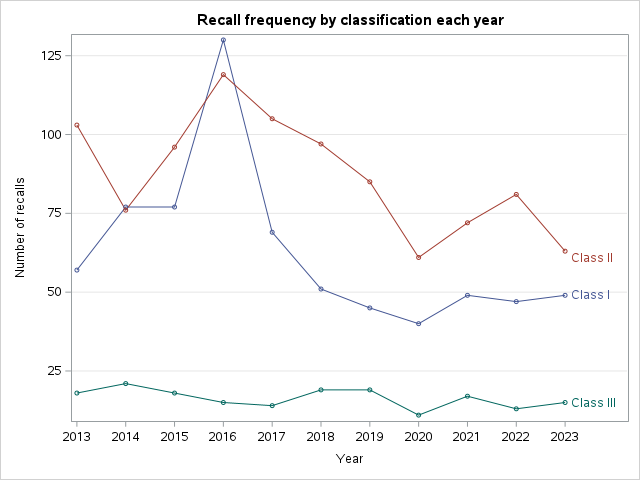
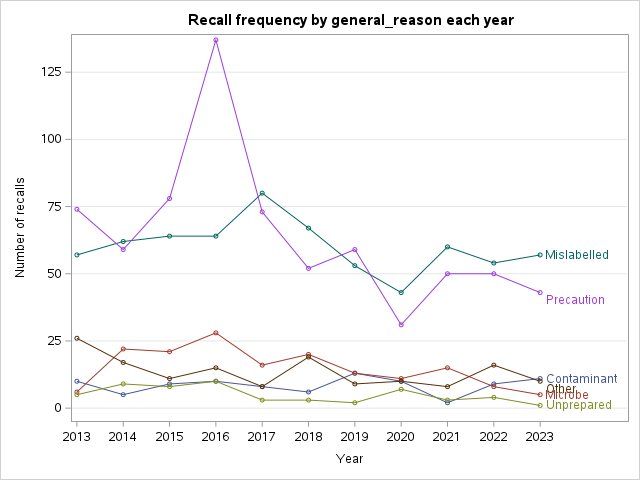
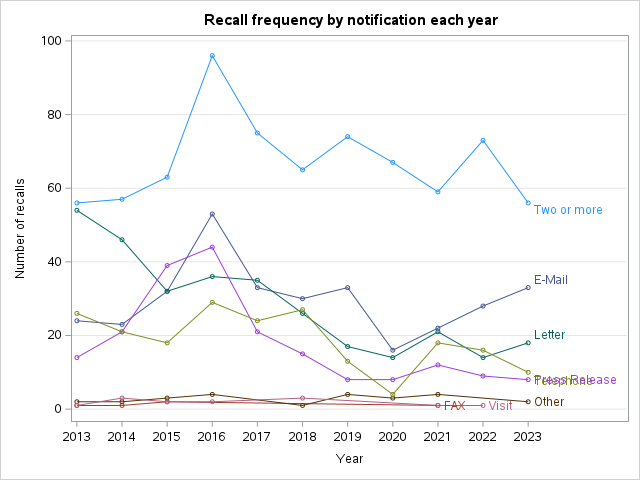

In [7]:
* output freqcount data set;
proc freq data=recalls noprint;
	table date1year*usda_region/ out=freqcount1;
	table date1year*general_reason / out=freqcount2;
	table date1year*notification/ out=freqcount3;
	table date1year*classification / out=freqcount4;
run;

%macro series(num=, var=);

title "Recall frequency by &var each year";
proc sgplot data=freqcount&num;
	series x=date1year y=count / group=&var markers markerattrs=(size=5pt) curvelabel;
	label count='Number of recalls';
	label date1year = 'Year';
    yaxis grid;
	keylegend / location=outside position=bottom ;
run;

title;
%mend series;

%series(num=4, var=classification);
%series(num=2, var=general_reason);
%series(num=3, var=notification);



### Number of days to process recall by:

* year
* region
* recall reason
* notification method
* classification (hazard)


#### Boxplots


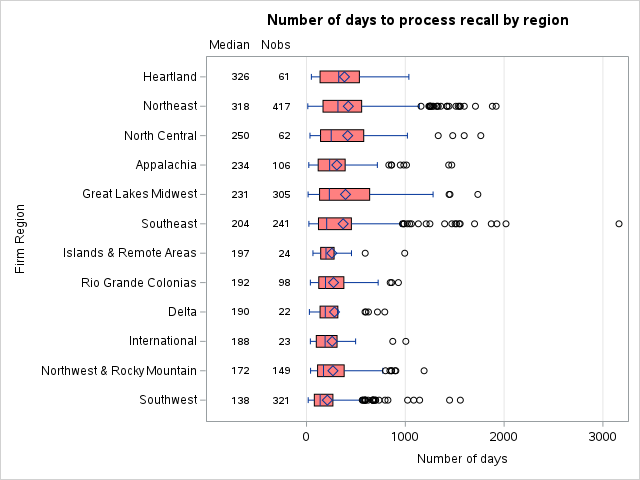
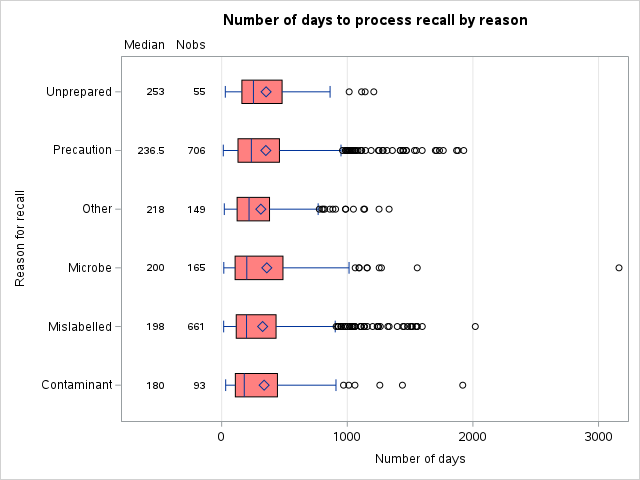
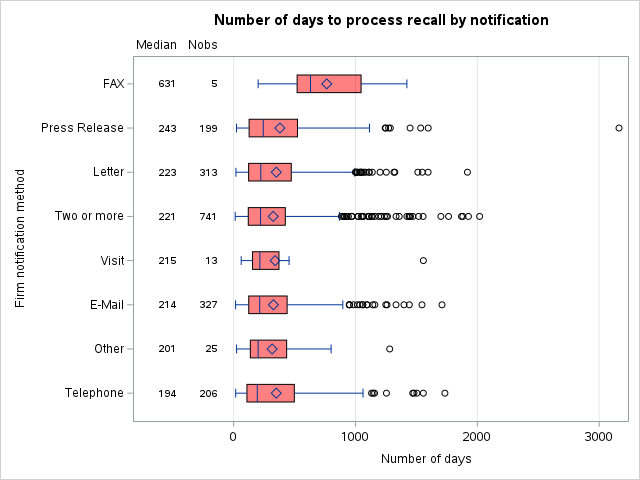
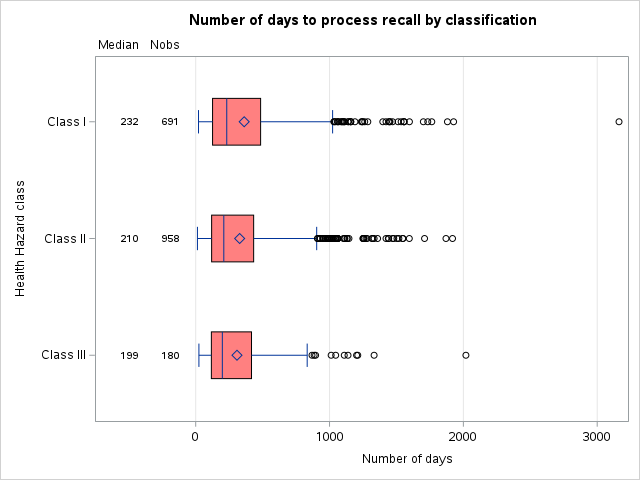
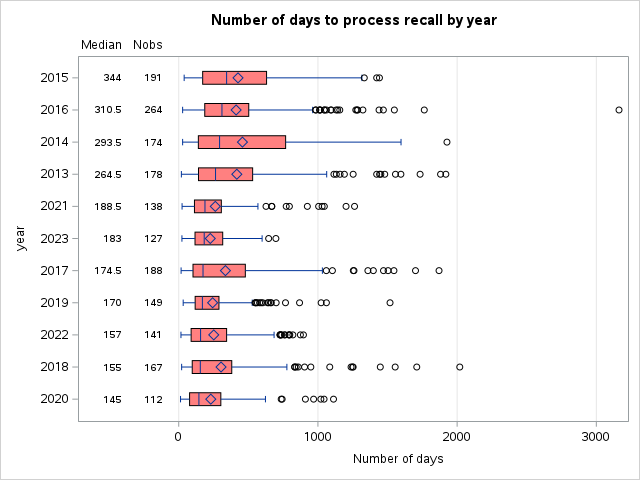

In [8]:


* macro sort by decreasing median then plot boxplots;
%macro sortboxplot(var=, topic=, label=);

* sort &topic by decreasing median;
proc sql;
create table sort_&topic as 
select *, median(days) as med_&topic
	from recalls
    group by &var
    order by med_&topic descending;
quit;

* boxplot of days by &var;
title "Number of days to process recall by &topic";
proc sgplot data=sort_&topic;
	hbox days / category=&var displaystats=(n median) fillattrs=(color=red transparency=0.5);
	xaxis grid;
	yaxis discreteorder=data;
	label days='Number of days';
	label &var ="&label";
run;
title;

%mend sortboxplot;

%sortboxplot(var=usda_region, topic=region, label=Firm Region);
%sortboxplot(var=general_reason, topic=reason, label=Reason for recall);
%sortboxplot(var=notification, topic=notification, label=Firm notification method);
%sortboxplot(var=classification, topic=classification, label=Health Hazard class);
%sortboxplot(var=date1year, topic=year, label=year);


In [9]:
ods graphics / reset;

%macro norm(cat=, label=);

* Test for normality;
ods select TestsForNormality Plots;
title "Normality tests by &label.";
proc univariate data=recalls plots normal;
	class &cat.;
	var days;
run;
	
%mend norm;


%norm(cat=usda_region, label=region);
%norm(cat=general_reason, label=general reason);
%norm(cat=notification, label=notification method);
%norm(cat=classification, label=health hazard class);
%norm(cat=date1year, label=year);


One of the required assumptions for a 1-way ANOVA is that data should be normally-distributed within each group level. Because the variables for region, reason, notification, classification, and year do not meet the normality assumption, I use a non-parametric ANOVA test (Kruskal-Wallis) to test differences in number of days across group levels for each variable.

#### Hypotheses for Kruskal-Wallis Test: 

**Region**

H0: usda_region (12 levels) medians are equal

HA: at least one median is different

**Reason**

H0: general_reason (6 levels) medians are equal

HA: at least one median is different

**Notification**

H0: notification (8 levels) medians are equal

HA: at least one median is different

**Classification**

H0: classification (3 levels) medians are equal

HA: at least one median is different

**Year**

H0: year (13 levels) medians are equal

HA: at least one median is different;

In [10]:
ods graphics / reset;

%macro kwallis(cat=, label=);

title "Non-parametric Kruskal-Wallis and post-hoc tests of days by &label.";

* Kruskall-Wallis test, alternative to ANOVA when observations are not nearly normal;
proc npar1way data=recalls wilcoxon dscf;
    class &cat.;
    var days;
run;

%mend kwallis;

%kwallis(cat=usda_region, label=region);
%kwallis(cat=general_reason, label=general reason);
%kwallis(cat=notification, label=notification method);
%kwallis(cat=classification, label=health hazard class);
%kwallis(cat=date1year, label=year);

By using 1-way nonparametric Kruskal-Wallis tests, the variables that showed significant differences in number of days to process recalled food products across group level were year (p-value = <0.0001) and region (p-value = <0.0001). We reject the null hypothesis that the medians are equal across group levels for year and region. There is sufficient evidence to suggest that at least one of the median level differs from the other levels by year and region.

Post-hoc pairwise comparison tests showed that Year 2015 and Year 2020 differed by the highest discrepancy in mean score number of days (p-value = <0.0001). Also, the Northeast and Southwest regions differed by the highest discrepancy in mean score number of days (p-value = <0.0001). 

### Recall frequency by geographic map:

* state
* usda_region


In [11]:
options nonotes nosource;
* recall frequency by state;
proc sql;
	create table forstatemap as 
	select distinct(count(event_id)) as count_event, usda_region, state, country
	from recalls
	where country= 'United States' and state ne 'PR'
    group by state
    order by count_event descending ;
quit;

* recall frequency by region;
proc sql;
	create table forregionmap as 
	select distinct(count(event_id)) as count_event, usda_region, state, country
	from recalls
    group by usda_region
    order by count_event descending ;
quit;


435  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
435! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml10.htm
436  
437  options nonotes nosource;




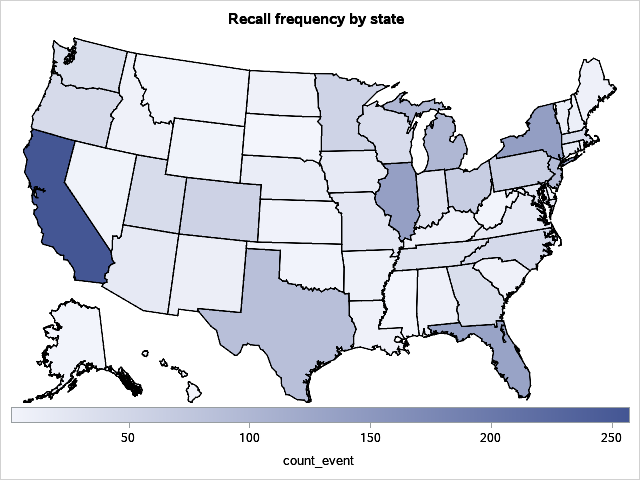

In [12]:
proc gproject data=mapsgfk.us_states out=my_map(drop=state rename=(statecode=state))
    latlong eastlong degrees;
    id statecode;
run;

/* display map frequency by state */
ods path(prepend) work.templat(update);
proc template;
define style styles.my_grad;
parent=styles.htmlblue;
 style twocolorramp / startcolor=grayee endcolor=gray55;
end;
run;

title1 "Recall frequency by state";
proc sgmap maprespdata=forstatemap mapdata=mapsgfk.us;
choromap count_event / mapid=statecode id=state;
run;
title;



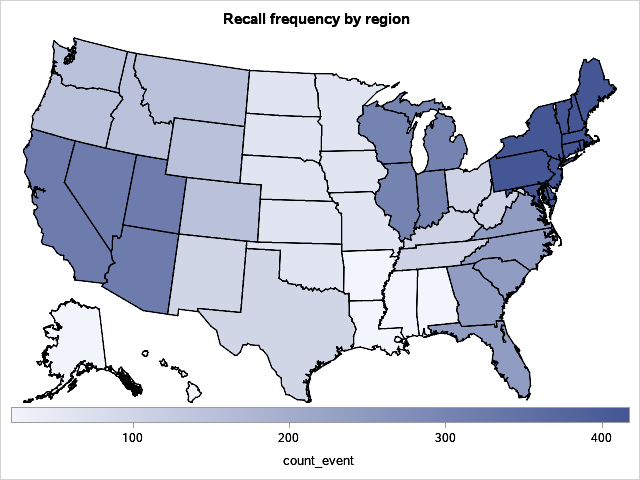

In [13]:


proc gproject data=mapsgfk.us_states out=my_map(drop=state rename=(statecode=state)) 
    latlong eastlong degrees;
    id statecode;
run;

goptions reset=all border;

/* display map frequency by region */
ods path(prepend) work.templat(update);
proc template;
define style styles.my_grad;
parent=styles.htmlblue;
 style twocolorramp / startcolor=grayee endcolor=gray55;
end;
run;

title1 "Recall frequency by region";
proc sgmap maprespdata=forregionmap mapdata=mapsgfk.us;
choromap count_event / mapid=statecode id=state;
run;
title;


### Number of days to process recall by geographic map:

* state
* usda_region


In [14]:
options nonotes nosource;
* recall days by state;
proc sql;
    create table statedays as
	select distinct(state), median(days) as med, country
	from recalls
	where country= 'United States' and state ne 'PR'
    group by state
    order by med descending;
quit;

* recall days by region;
proc sql;
    create table regiondays as
	select distinct(usda_region), median(days) as med, country, state
	from recalls
	where country= 'United States' and state ne 'PR'
    group by usda_region
    order by med descending;
quit;



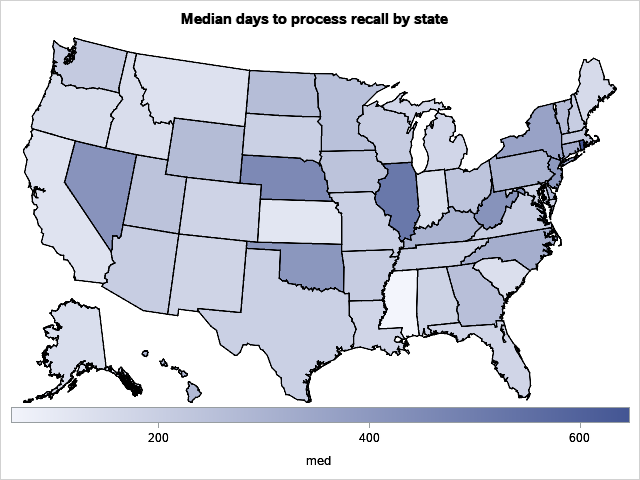

In [15]:
proc gproject data=mapsgfk.us_states out=my_map(drop=state rename=(statecode=state))
    latlong eastlong degrees;
    id statecode;
run;

/* display map frequency by state */
ods path(prepend) work.templat(update);
proc template;
define style styles.my_grad;
parent=styles.htmlblue;
 style twocolorramp / startcolor=grayee endcolor=gray55;
end;
run;

title1 "Median days to process recall by state";
proc sgmap maprespdata=statedays mapdata=mapsgfk.us;
choromap med / mapid=statecode id=state;
run;
title;



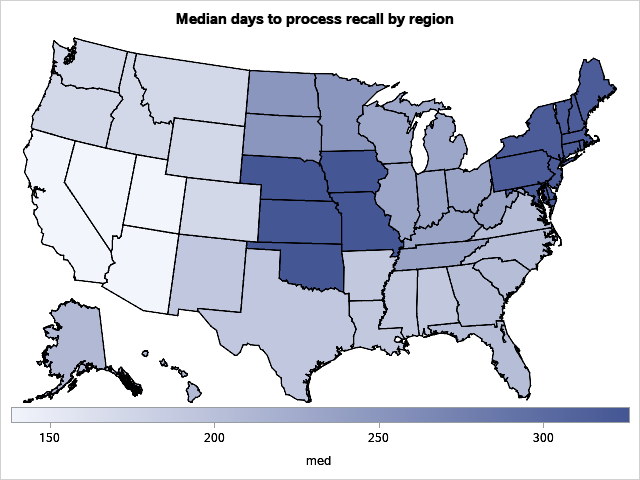

In [16]:
proc gproject data=mapsgfk.us_states out=my_map(drop=state rename=(statecode=state))
    latlong eastlong degrees;
    id statecode;
run;

/* display map frequency by state */
ods path(prepend) work.templat(update);
proc template;
define style styles.my_grad;
parent=styles.htmlblue;
 style twocolorramp / startcolor=grayee endcolor=gray55;
end;
run;

title1 "Median days to process recall by region";
proc sgmap maprespdata=regiondays mapdata=mapsgfk.us;
choromap med / mapid=statecode id=state;
run;
title;

### 4. Develop a codebook for understanding the final dataset structure and variables

In [17]:
ods noptitle;

%let descwidth=4.0;
%let Nwidth=.5;
%let valwidth=.5;

%macro mycodebook;

    /***Order variables alphabetically to present an ordered codebook***/
        proc sql noprint;
            select name into :alphalist separated by ' '
                from dictionary.columns
                where libname='WORK' and memname='RECALLS'
                order by name; *note: libname, memname must be ALL CAPS;
        quit;


    %let i=1;
 
    %do %until (%scan(&alphalist,&i)= );
        
        %let var=%scan(&alphalist,&i);


        /***Create a single title at the top of the codebook***/

        %if &var=%scan(&alphalist,1) %then %do;
            title "A codebook for variables in the final analysis dataset";
        %end;
        %else %do; title; %end;


        /***Get variable type and label***/
        data _null_;

            dsid = open("recalls");
            vtyp = vartype(dsid,varnum(dsid,"&var"));
            vlab = varlabel(dsid,varnum(dsid,"&var"));
            rc = close(dsid);
            
            length fulltype $9;
            if vtyp='N' and (index(upcase(vlab),'DATE'))>0 then fulltype='Date';
            if vtyp='N' and (index(upcase(vlab),'DATE'))=0 then fulltype='Numeric';
            if vtyp='C' then fulltype='Character';
            
            call symput("fulltyp",strip(fulltype));
            call symput("vlabl",strip(vlab));
        
        run;

        /***Procedure for DATE variables***/
        %if &fulltyp = Date %then %do;
            proc sql noprint;
            select count(&var) as c, nmiss(&var), min(&var) format=date9., max(&var) format=date9.
                    INTO :N, :Nmiss, :Minimum, :Maximum 
                from recalls
            order by c desc;
            quit;
        
            
            proc report data=recalls nowd style(header)={just=left};
                columns ("&var." count Value) ("&vlabl." Description);
                define count/computed "N" style={cellwidth=&Nwidth.in};
                define Value/computed style={cellwidth=&valwidth.in};
                define Description/computed 'Summary' style={cellwidth=&descwidth.in just=left};

                compute count;
                count= &N.;
                endcomp;

                compute Value/character length=17;
                Value= "Range";
                endcomp;

                compute Description/character length=50;
                Description= "&minimum. to &maximum. (Missing = %sysfunc(strip(&nmiss.)))";
                endcomp;
            run;
        
        %end;


        /***Procedure for other numeric variables apart from date variables***/
        %if &fulltyp = Numeric %then %do;

            proc sql noprint;
            select count(&var) as c, count(distinct &var) as c2, nmiss(&var), min(&var), max(&var),mean(&var) format = 6.2
                    INTO :N, :distinctN, :Nmiss, :Minimum, :Maximum ,:average
                from recalls
            order by c c2 desc;
            quit;
        
        %if &distinctN >= 15 %then %do;
        proc report data=recalls nowd style(header)={just=left};
            columns ("&var." count Value) ("&vlabl." Description);
            define count/computed "N" style={cellwidth=&Nwidth.in};
            define Value/computed style={cellwidth=&valwidth.in};
            define Description/computed 'Summary' style={cellwidth=&descwidth.in just=left};

            compute count;
            count= &N.;
            endcomp;

            compute Value/character length=17;
            Value= "Range";
            endcomp;

            compute Description/character length=55;
            Description= "%sysfunc(strip(&minimum.)) - %sysfunc(strip(&maximum.)) (Mean = %sysfunc(strip(&average.)), Missing = %sysfunc(strip(&nmiss.)))";
            endcomp;
        run;

        %end;

        %else %if &distinctN < 15 %then %do;

        proc freq data = recalls noprint;
        table &var/
            out = freq_&i;
        run;

        proc report data=freq_&i nowd style(header)={just=left} split="*";
            columns ("&var." count &var.) ("&vlabl." percent);
            define count/display "N" style={cellwidth=&Nwidth.in};
            define &var./display "Value" style={cellwidth=&valwidth.in};
            define percent/display "Percent of Total" style={cellwidth=&descwidth.in just=left} format=6.1;

        run;

        %end;
    
        %end;

        
        /***Procedure for character variables***/
        %if &fulltyp = Character %then %do; 
    
            proc sql noprint;
                select count(&var) as c, nmiss(&var), count(distinct &var)
                        INTO :N, :Nmiss, :unique_var 
                    from recalls
                order by c;
            quit;


        /***Character variables with less unique values***/
        %if &unique_var <=15 %then %do;

            proc freq data = recalls noprint order=freq;
                table &var/
                    out = freqout_&i;
            run;

            proc report data=freqout_&i nowd style(header)={just=left} split="*";
                columns ("&var." count &var.) ("&vlabl." percent);
                define count/display "N" style={cellwidth=&Nwidth.in};
                define &var./display "Value" style={cellwidth=&valwidth.in};
                define percent/display "Percent of Total" style={cellwidth=&descwidth.in just=left} format=6.1;

            run;
        
        %end;

        /***Character variables with several unique values***/
        %else %if &unique_var > 15 %then %do;

            proc report data = recalls nowd style(header)={just=left};
                columns ("&var." count value) ("&vlabl." Description);
                define count/computed "N" style={cellwidth=&Nwidth.in};
                define value/computed "Value" style={cellwidth=&valwidth.in};
                define Description/computed 'Summary' style={cellwidth=&descwidth.in just=left};

                compute count;
                count= &N.;
                endcomp;

                compute value/character length=10;
                value= "ID's";
                endcomp;

                compute Description/character length=50;
                Description= "Unique values = %sysfunc(strip(&unique_var.)), Missing = %sysfunc(strip(&nmiss.))";
                endcomp;
            run;    
        %end; 

        %end;

        %let i=%eval(&i+1);
    %end;
        
    quit;
     

%mend;
%mycodebook;